
# **1 Motivation**

At the top-level, this problem set enables you to turn your cell phone into a 4D light field camera.

In class we learned how ”Bokeh” and shallow depth of field is a desirable aesthetic quality in a photograph. Unfortunately, this effect requires a large aperture, i.e., the lens is going to be big and bulky! But what if it was possible to turn your cell phone into a camera with a large aperture? What if we could selectively focus on objects in post-processing?

The goal of this homework is to synthesize images with smaller depths of field thus making it appear to have been taken
from an expensive camera with a larger aperture [2] [4]. Figure 1a and b show a scene image with the corresponding
synthetic aperture image with lower depth of field.

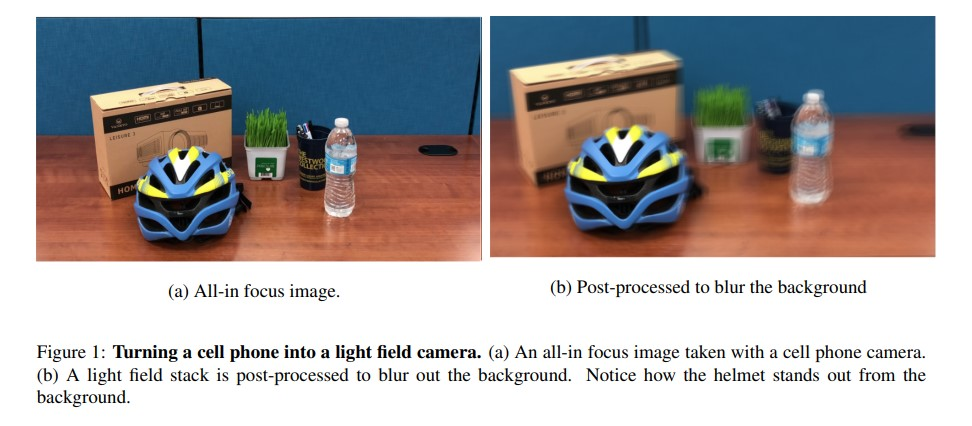

# **2 Experimental Component**

We will capture a video by moving the camera in a zig-zag path as shown in Figure 2 in front of the static scene. Unless otherwise discussed with the instruction staff, please use Python for all codes. Fill in each box below for credit.
Please note:
1. The algorithm being implemented does not take camera tilt into account. Avoid tilting and rotating the camera
as much as possible.
2. The instruction set use a planar zig-zag path for camera motion as in 2. However, you are allowed to try different paths like circular or polyline.
3. The number of frames in the video captured will determine the time required to compute the output. Make sure the video is not too long.


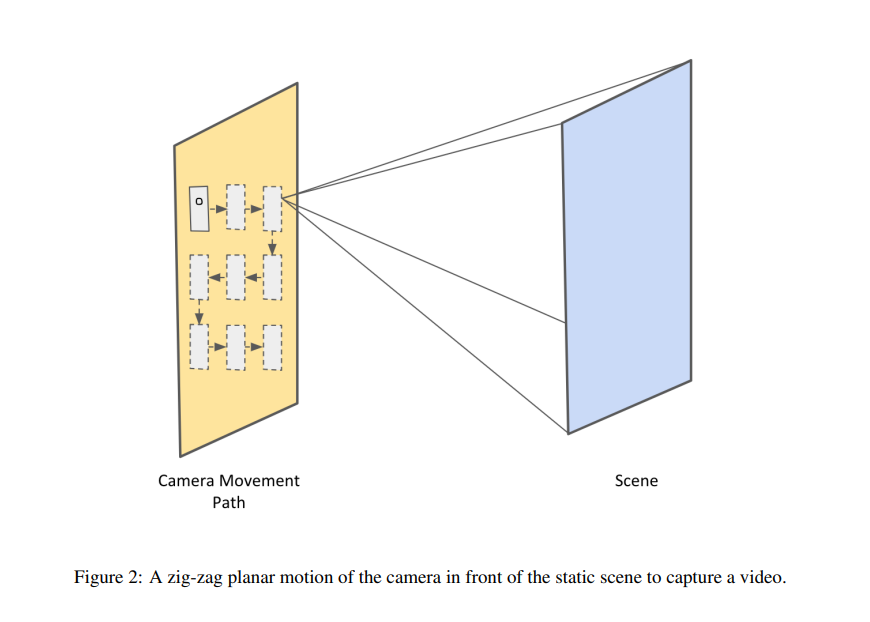

**2.1 Set up a Static Scene**

Set up a static scene similar to the one shown in Figure 1a. Try to have objects at different depths. For credit, place
your image in the box below (replace our office scene with your own scene).

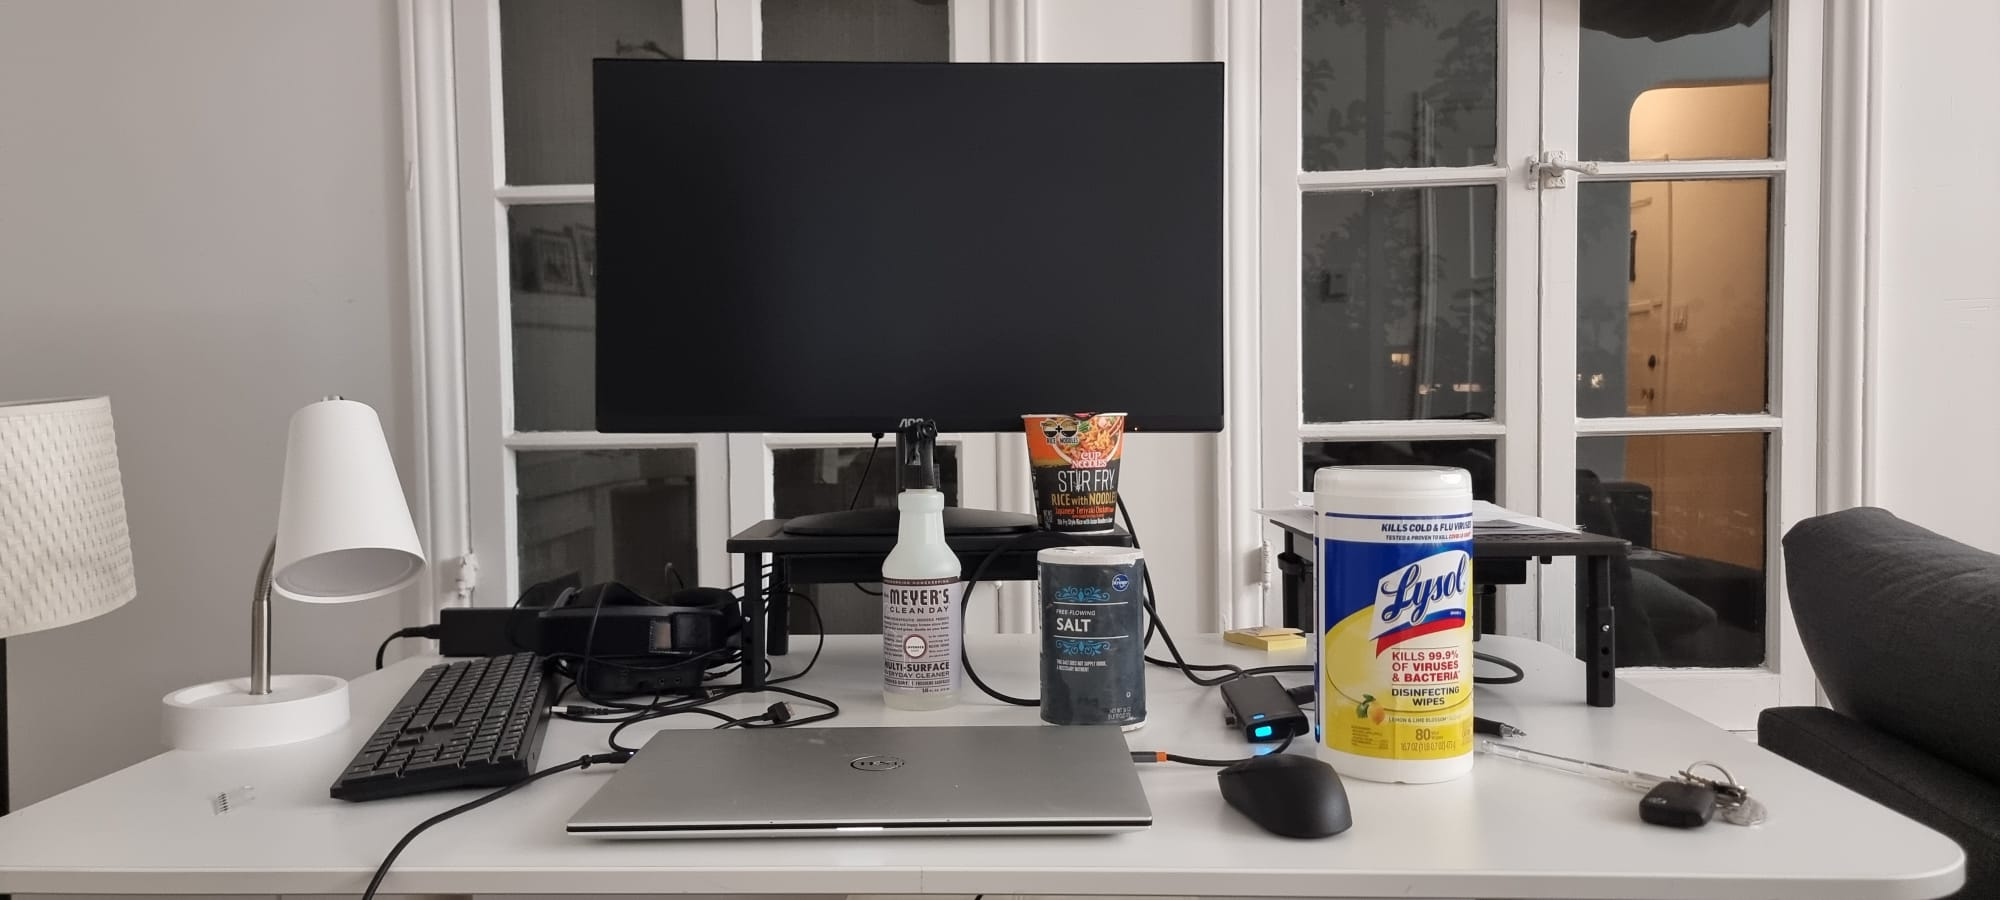

Figure 3:
$\color{blue}{\text{Insert an ordinary photograph of the scene (replace our example).}}$

In [2]:
# If on Google Drive, you can mount your drive so you can save your work

# Mount google drive and go to drive
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')
%cd "drive/My Drive/HW2_CI_2"


Mounted at /content/drive
/content/drive/My Drive/HW2_CI_2


In [3]:
# Important imports you may use

import numpy as np
import cv2
from scipy.signal import correlate2d
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.contrib import tzip

In [4]:
def check_code_correctness(test_function, *test_in, test_out):
    """Checks if the given function behaves as expected

    Args:
      test_function: Function to test
      *test_in: The sample inputs to test on (can be multiple)
      test_out: The expected output of the function given the specified input

    Returns:
      True if the function behaves as expected, False otherwise (wrong answer or error)
    """

    try:
        # Using *test_in to unpack the arguments and pass to the test_function
        student_out = test_function(*test_in)
    except NotImplementedError as err:
        print("Please implement and remove \'raise NotImplementedError\' ")
        return False
    except RuntimeError as err:
        print("Please make sure you have the right dimensions and type")
        return False
    except:
        print("An exception occurred: could not compute output")
        return False

    try:
        if not( np.allclose(student_out, test_out) ):
            print("Test failed, student output does not match test output")
            return False
    except TypeError as err:
        print("Please make sure your function outputs the correct type")
        return False
    except:
        print("An exception occurred: could not check output")
        return False

    return True

In [ ]:
#!gdown https://drive.google.com/uc?id=1bOvWufL9ZftzqRxIBXSpp_qI-hZmddt4
#!unzip sol_1.zip

**2.2 Capture a 4D Light Field**

Take a video by waving your camera in front of the scene by following a specific planar motion. The more you cover
the plane, the better will be your results. Ensure that all objects are in focus in your video. For credit, place three
frames of the video in the box below (replace our example). These frames differ in their parallax, i.e., an effect where
object positions change in response to view.


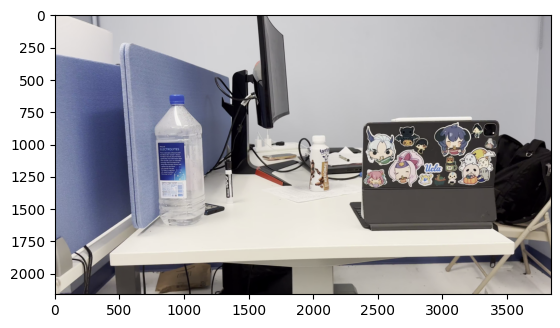

**2.3.1 Acquiring the Data**

Write a function to read your video file and convert the video into a sequence of frames. Since this was captured from
a cell phone, each frame image is in RGB color. Write a script to convert each frame to gray-scale. For credit, place
the gray scale image of the first frame of your video in the box below (replace our example).

In [5]:
# Student TODO: Create a script to load a video and extract the frames into an
# array named "frames_color". You must extract color frames. Grayscale frames are
# optional, as they'll help with computation time. OpenCV will likely be useful for this.

video_capture = cv2.VideoCapture('video1.mp4')


if not video_capture.isOpened():
    print("Error: Could not open video file.")
    exit()

frame_count = 0
frames = []
frames_color = []
while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray_frame)
    frames_color.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    frame_count += 1

video_capture.release()

print(f"Extracted {frame_count} frames.")


frames = np.array(frames)
print(frames.shape)

frames_color = np.array(frames_color)
print(frames_color.shape)

Extracted 551 frames.
(551, 480, 848)
(551, 480, 848, 3)


In [6]:
frames = frames[:400,:,:] #handshake at the last frames, so discarded them
frames_color = frames_color[:400,:,:,:]

**2.3.2 Displaying Frames**

To ensure that your function reads the frames of the video correctly, plot some of the frames below (replace our example).

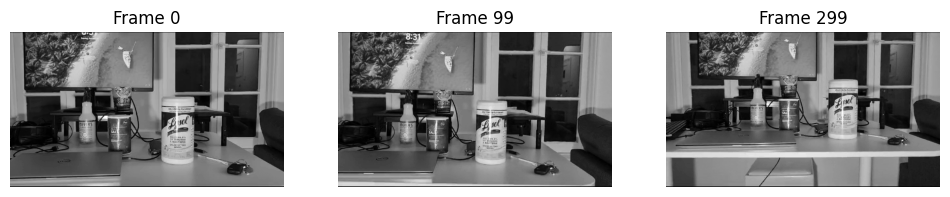

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(frames[0,:,:],cmap='gray')
axes[0].set_title('Frame 0')

axes[1].imshow(frames[99,:,:],cmap='gray')
axes[1].set_title('Frame 99')

axes[2].imshow(frames[299,:,:],cmap='gray')
axes[2].set_title('Frame 299')

for ax in axes:
    ax.axis('off')

plt.show()

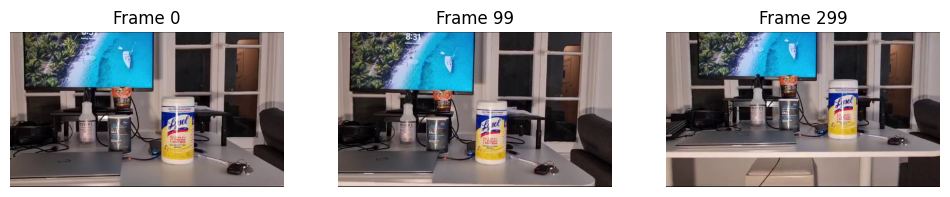

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(frames_color[0,:,:,:])
axes[0].set_title('Frame 0')

axes[1].imshow(frames_color[99,:,:,:])
axes[1].set_title('Frame 99')

axes[2].imshow(frames_color[299,:,:,:])
axes[2].set_title('Frame 299')

for ax in axes:
    ax.axis('off')

plt.show()

Figure 4: $\color{blue}{\text{Insert any three frames of your video here (replace our example). Make sure there is sufficient parallax
in the images.}}$


**2.4 Registering the Frames**


***2.4.1 Template and Window***

From the first frame of your video, select an object as a template. We will be registering all other frames of the video
with respect to this template. Once a template has been selected in the first frame, we search for it in the subsequent
frames. The location of the template in a target frame image will give us the shift(in pixels) of the camera. Since we
don’t have to search for the template in the entire target frame image, we select a window to perform this operation.
Note, however, that selecting a window is optional. This is done just to reduce the computation time. For credit, place
the image of the first frame of your video in the box below with the template and the window markings (replace our
example)

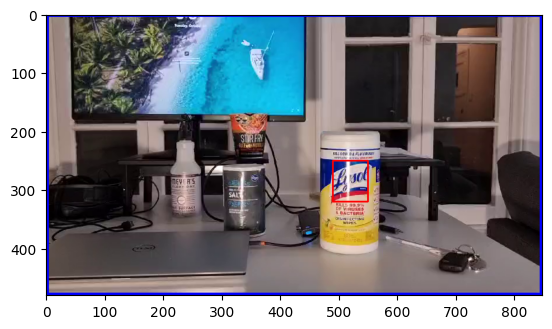

# **Window is marked with blue frame, and template is marked with red frame**

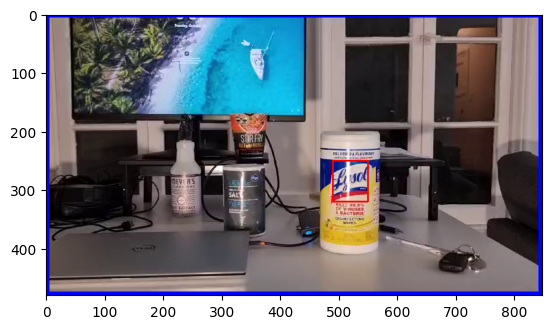

In [9]:
# Define box coordinates (left-top and right-bottom points)

start_template = [490,250]
end_template = [550,320]
start_window = [0,0]
end_window = [847,479] #480, 848

box_color_blue = (0,0,255) #RGB
box_color_red = (255,0,0)
image = frames_color[0,:,:,:].copy()

image = cv2.rectangle(image, start_template, end_template, box_color_red, 2)
image = cv2.rectangle(image, start_window, end_window, box_color_blue, 10)

plt.imshow(image)
plt.show()

Figure 6: $\color{blue}{\text{Insert your image with template object and search window marked (replace our example).}}$


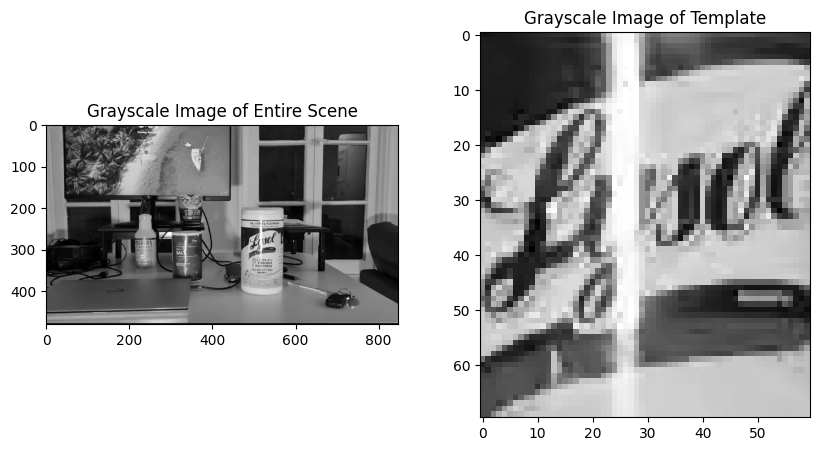

In [10]:
# Student TODO: Select a template in the first frame of the video.
# A template is an object that you'd like to focus on.
# It is optional to select a frame that bound the deviation of the entire object.
# Create a window to operate in can decrease computation time significantly,
# though it depends on your methods of computation.

# Select woman eating ramen
# [x_start, x_end, y_start, y_end]
template_bounds = [490,550,250,320]
template = frames[0, template_bounds[2]:template_bounds[3], template_bounds[0]:template_bounds[1]]

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
axes[0].set_title("Grayscale Image of Entire Scene")
axes[1].set_title("Grayscale Image of Template")
axes[0].imshow(frames[0], cmap='gray')
axes[1].imshow(template, cmap='gray')
plt.show()

***2.4.2 Normalized Cross Correlation***

Perform a normalized cross correlation of the template with the extracted search window. Let $A[i, j]$ be the normalized cross-correlation coefficient. If $t[n,m]$ is our template image and $w[n,m]$ is our window,
then from [3] we have:

$$ A[i,j] = \frac{\sum_{n,m=1}^{T} [w(n,m)-\bar{w}_{i,j}][t(n-i.m-j)-\bar{t}]}{\sqrt{\sum_{n,m=1}^{T}[w(n,m)-\bar{w}_{i,j}]^2[t(n-i,m-j)-\bar{t}]^2}}$$

where, $\bar{t}$ is the mean of the template and $\bar{w}_{i,j}$ is the mean of the window $w[n,m]$ in the region under the template. Plot the cross correlation coefficient matrix $A[i,j]$ for one of the frames. For credit, place the plot in the box below. (replace our example)


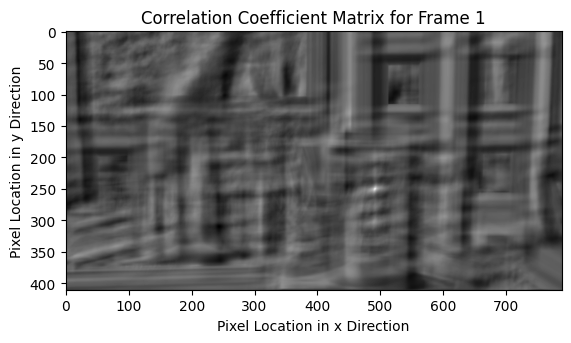

Figure 7: $\color{blue}{\text{Insert the plot of the correlation coefficient Matrix (replace our example).}}$

*Hint: Use the OpenCV Library.*

In [11]:
# Student TODO: Create a function to compute all the coefficients of the
# correlation coefficient matrix for a given frame.

def compute_A_matrix(template, window):
    # Compute the normalized cross-correlation using OpenCV's matchTemplate
    method = cv2.TM_CCOEFF_NORMED
    result = cv2.matchTemplate(window, template, method)
    return result

In [12]:
test_template = np.load('sol_1/template_1.npy')
test_window = np.load('sol_1/frame_1.npy')
test_sol = np.load('sol_1/NCC.npy')
check_code_correctness(compute_A_matrix, test_template, test_window, test_out=test_sol)

True

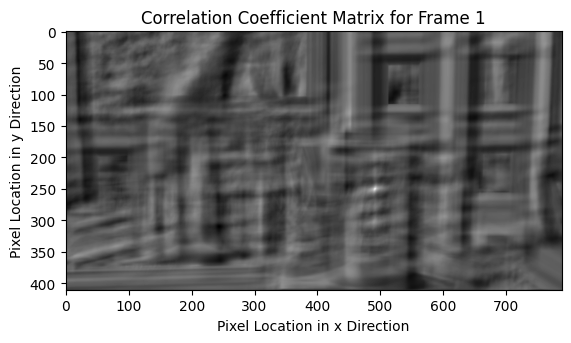

In [13]:
# Student TODO: Run your code on the first frame and visualize. Ensure the brightest point
# is on your template.

# Sanity check
plt.title("Correlation Coefficient Matrix for Frame 1")
plt.xlabel("Pixel Location in x Direction")
plt.ylabel("Pixel Location in y Direction")
Matrix_A = compute_A_matrix(template,frames[0])
plt.imshow(Matrix_A, cmap='gray')
plt.show()

***2.4.3 Retrieving the Pixel Shifts***

The location that yields the maximum value of the coefficient $A[i, j]$ is used to compute the shift. The shift in pixels for each frame can be found by:

$$[sx,sy] = max_{i,j}{A[i,j]}.$$

For credit, please place the plot of sx v/s sy in the box below (replace our example)

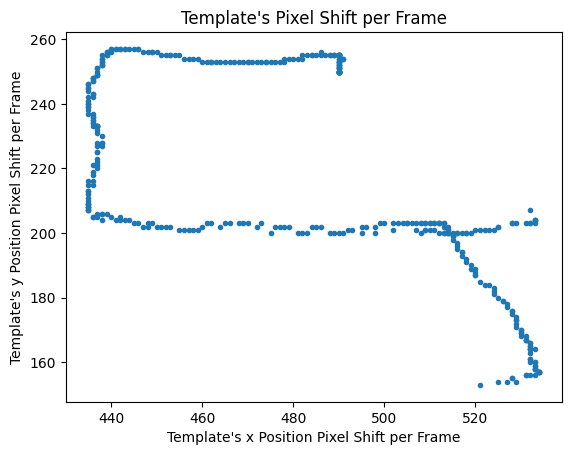

Figure 8: $\color{blue}{\text{Insert the plot of X pixel shift v/s Y pixel shift (replace our example).}}$


In [14]:
# Student TODO: Create a script to compute the A matrix for every frame
# and compute the pixel shift for each A matrix by taking the max value.

# Compute every A matrix and compute the shifts
# This function should return a numpy array of size (N,2)
# where N is the number of frames and the shifts are in (y,x) order

# Hint: np.argmax may help here
def compute_shifts(template, frames):
    n_frames = frames.shape[0]
    max_list = []
    for i in range(n_frames):
      A_matrix = compute_A_matrix(template,frames[i])
      sy,sx = np.unravel_index(np.argmax(A_matrix), A_matrix.shape)
      max_list.append(np.array([sy,sx]))
    return np.array(max_list)


In [15]:
test_template = np.load('sol_1/template_1.npy')
test_frames = np.load('sol_1/frames.npy')
test_sol = np.load('sol_1/shifts.npy')
check_code_correctness(compute_shifts, test_template, test_frames, test_out=test_sol)

True

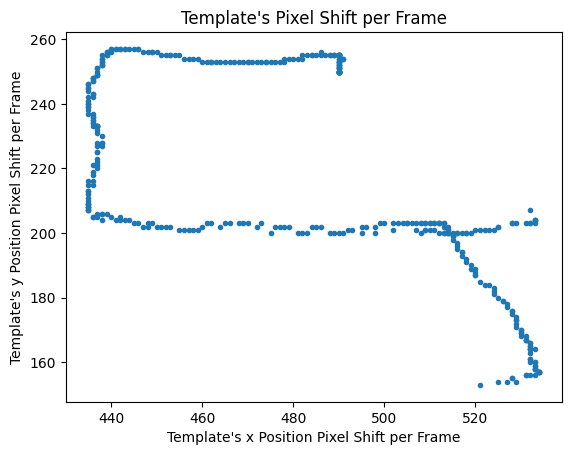

In [16]:
# Student TODO: Plot your shifts and make sure they match the video you took

# Plotting shifts using matplotlib
# Pay attention to what is X and Y
shifts = compute_shifts(template, frames)
plt.title("Template's Pixel Shift per Frame")
plt.xlabel("Template's x Position Pixel Shift per Frame")
plt.ylabel("Template's y Position Pixel Shift per Frame")
plt.plot(shifts[:,1],shifts[:,0], '.')
plt.show()

**2.5 Synthesizing an Image with Synthetic Aperture**

Once you have the pixel shifts for each frame, you can synthesize refocused image by shifting each frame in the opposite direction and then summing up all the frames. (Note: in Section 3, you will need to explain why this operation works. Start thinking about this now!) Suppose the pixel shift vector for Frame Image $I_i[n,m]$ is $[s_{xi},s_{yi}]$. Then, the image output, $P[n,m]$ with synthetic
aperture is obtained as:

$$P[n,m] = \sum_{i}{I_i[n-s_{xi},m-s_{yi}]}$$

For credit, place your synthetically ”defocused” image in the box below (replace our example).

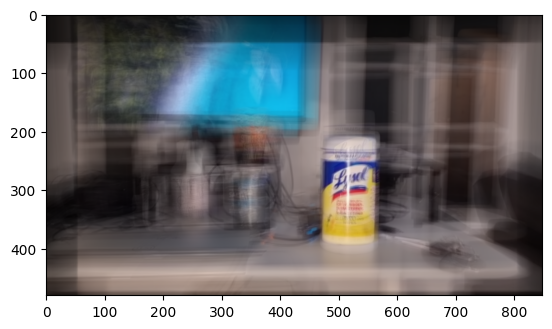

Figure 9: $\color{blue}{\text{Insert an image with an object in synthetic focus (replace our example).}}$


In [17]:
# Student TODO: Use the shifts to synthetically defocus your image using the
# above equation.
# Hint: Remember to align your images to the first frame.
# Hint: the warpAffine function from opencv may be useful

# Compute sythnetically "defocused" image
# The output should be the same size as your input frames.
def compute_defocused_image(frames_color, shifts):
  n_frames = shifts.shape[0]
  W,H,C = frames_color.shape[1:]
  sum = np.zeros(frames_color.shape[1:]).astype(np.float32)

  for i in range(n_frames):
    sy,sx = shifts[i,0], shifts[i,1]
    ty,tx = shifts[0,0] - sy, shifts[0,1] - sx
    t_matrix = np.array([
      [1, 0, tx],
      [0, 1, ty]
    ], dtype=np.float32)

    warped = np.zeros((W,H,C))
    for j in range(C):
      warped[:,:,j] = cv2.warpAffine(frames_color[i,:,:,j], t_matrix, (H, W)).astype(np.float32)
    sum += warped
    defocus_img = (sum/(n_frames)).astype(int)
  return defocus_img

In [18]:
test_frames_color = np.load('sol_1/frames_color.npy')
test_shifts = np.load('sol_1/shifts.npy')
test_sol = np.load('sol_1/defocused_image.npy')
check_code_correctness(compute_defocused_image, test_frames_color, test_shifts, test_out=test_sol)

True

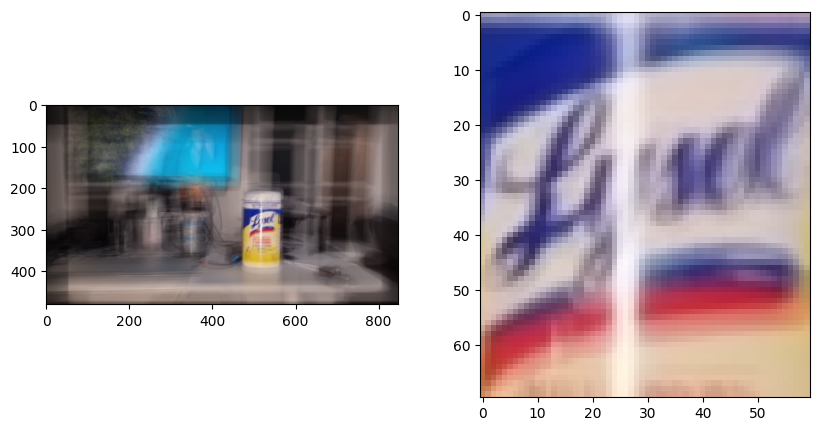

In [19]:
defocused_image = compute_defocused_image(frames_color, shifts)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axes[0].imshow(defocused_image)
axes[1].imshow(defocused_image[template_bounds[2]:template_bounds[3], template_bounds[0]:template_bounds[1]])
plt.show()

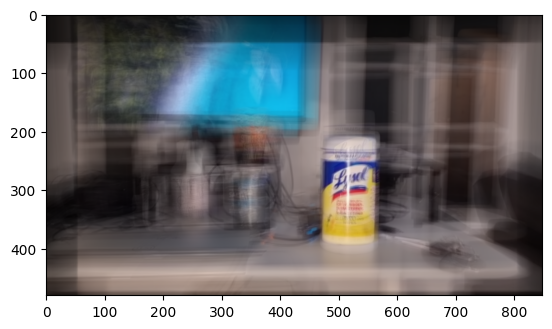

In [20]:
plt.imshow(defocused_image)
plt.show()

**2.6 Repeating the Experiment for Different Templates**

Now, we will exploit the fact that we can synthetically focus on different depths. To do this, select a new object as your template and repeat all the steps to generate an image that is focused on this new object. Here, we have selected the UCLA logo as our new object. For credit, place a de-focused image with a different template object in focus in the box below (replace our example).

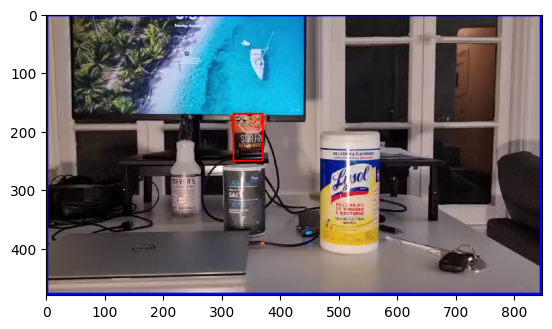

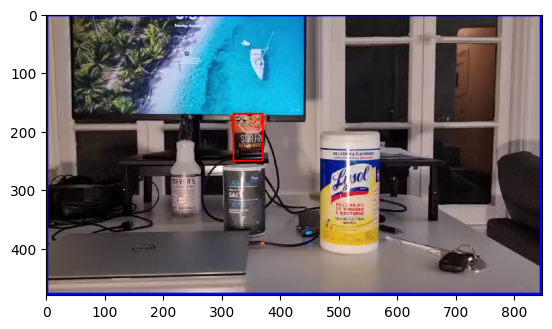

In [21]:
# Define box coordinates (left-top and right-bottom points)

start_template = [320,170]
end_template = [370,250]
start_window = [0,0]
end_window = [847,479] #480, 848

box_color_blue = (0,0,255) #RGB
box_color_red = (255,0,0)
image = frames_color[0,:,:,:].copy()

image = cv2.rectangle(image, start_template, end_template, box_color_red, 2)
image = cv2.rectangle(image, start_window, end_window, box_color_blue, 5)

plt.imshow(image)
plt.show()

(80, 50)


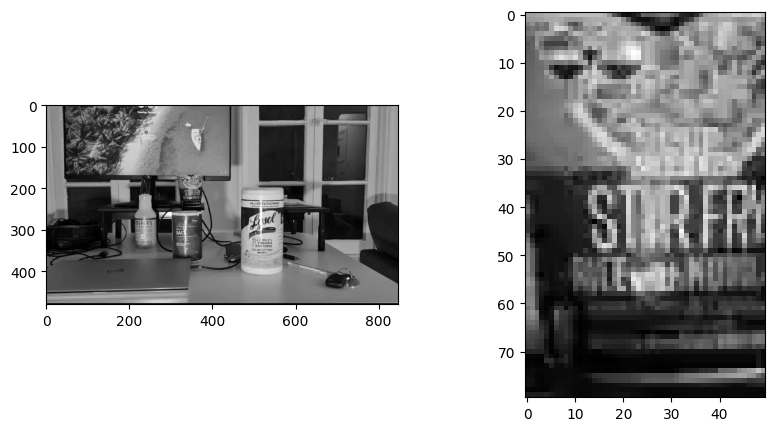

In [22]:
# Student TODO: Select a new template.

# Select STIRFRY cup noodle as a new template
template_bounds = [320,370,170,250]
template = frames[0, template_bounds[2]:template_bounds[3], template_bounds[0]:template_bounds[1]]
print(template.shape)

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
axes[0].imshow(frames[0], cmap='gray')
axes[1].imshow(template, cmap='gray')
plt.show()

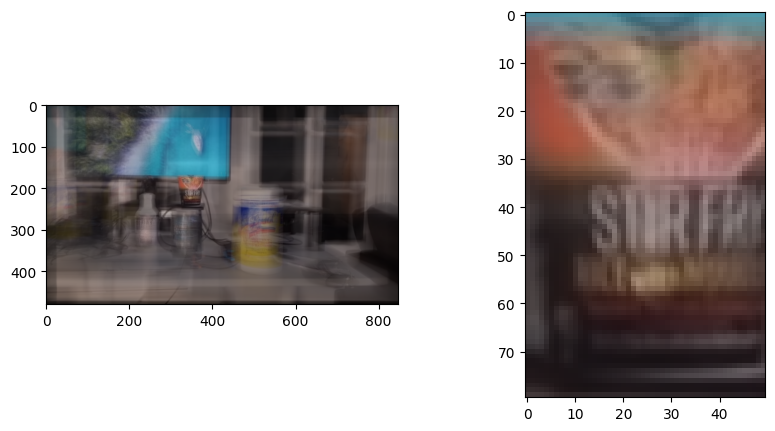

In [23]:
# Student TODO: Rerun the previous code to get a synthetically "defocused" image
# for your new template.

# Recompute defocused image
Matrix_A = compute_A_matrix(template,frames[0])
shifts = compute_shifts(template, frames)
defocused_image = compute_defocused_image(frames_color, shifts)

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
axes[0].imshow(defocused_image)
axes[1].imshow(defocused_image[template_bounds[2]:template_bounds[3], template_bounds[0]:template_bounds[1]])
plt.show()

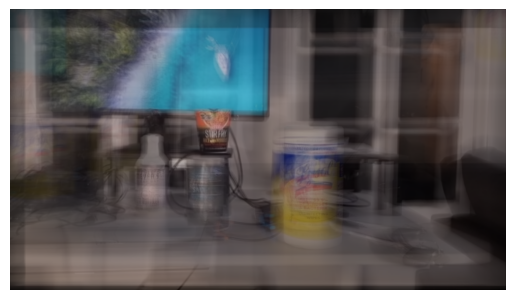

In [24]:
plt.imshow(defocused_image)
plt.axis('off')
plt.show()

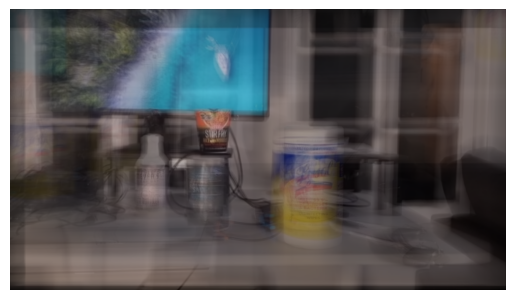

Figure 10: $\color{blue}{\text{Insert an image with an object in synthetic focus. This object should be different from the previous box (replace our example).}}$

# **3 Assessment**

The goal is to understand how much blur is synthetically added by using a model of pinhole cameras. Consider the
coordinate diagram shown in Figure 11. Here, [X1,Z1] is a scene point of an object in the template, [X2,Z2] is a scene
point of an object in the background and C(i) for i = 1,...,k are positions of the apertures of cameras at which the
scene is captured. The maximum camera translation is ∆ and f is the focal length of the cameras (all are assumed to
be the same).

**3.1 Deriving the Blur Kernel Width**

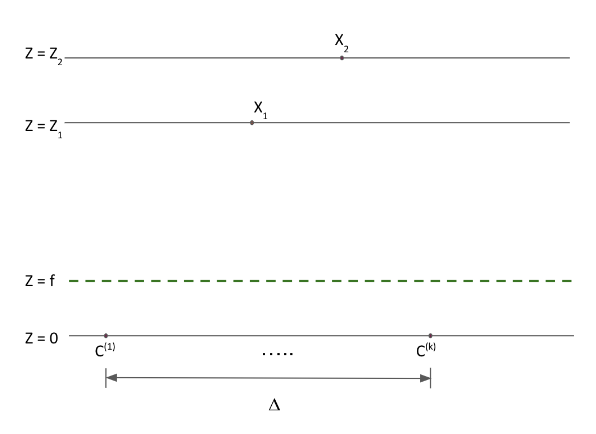


Figure 11: Example coordinate system and notation. In this figure, the dashed plane is the virtual film plane, placed
one focal length above the apertures located at $C^{(1)},...,C^{(k)}$. This is a common shorthand convention so we do not
have to flip the camera images. In reality, the actual film plane would be one focal length below the aperture location.
This coordinate system is used as a guide - you are welcome to modify as needed.

We will use the shift-and-add method for light field imaging such that $X_1$ is the point in focus (i.e. as the ”template”
that we shift and add”). As we shift between camera views, the location $X_1$ and $X_2$ get projected to shift as well. Derive a mathematical expression for the size of the blur kernel ($W$) applied to $X_2$. Since $X_1$ is the point in focus, finding the blur kernel is equivalent to finding the difference between the range of $x_1$ and $x_2$, where $x_1$ and $x_2$ are the corresponding projected pixels on the sensor. Credit will be assessed both for technical correctness and the presentation of the derivation. You should not need figures, but are welcome to include them. Insert your derivation in the box below. Please write it in Latex.

[Hint: Our solution to derive W was about a half page.]

[Hint: To check your solution, if $Z_1 = Z_2$ the width of the blur kernel should be zero.]

We can obtain the range of $x_1$ and $x_2$ if we draw a straight line from apertures to point in focuses at different depths. This will create two triangles and intersection between the triangle and the $z = f$ plane will give us the range of $x_1$ and $x_2$.
Denote the range of $x_1$ as $R_1$ and range of $x_2$ as $R_2$. Then, $W = |R_2 -R_1|$. \\
Using the Triangle Similarity, we can write the following:
$$ \frac{\Delta}{R_1} = \frac{z_1}{z_1 - f} $$
$$ \frac{\Delta}{R_2} = \frac{z_2}{z_2 - f}  $$ \\
Then $R_2$ and $R_1$ can be written as:
$$ R_1 = (\frac{z_1 - f}{z_1})\Delta = (1- \frac{f}{z_1})\Delta $$
$$ R_2 = (\frac{z_2 - f}{z_2})\Delta = (1- \frac{f}{z_2})\Delta $$

$$W = | R_2 - R_1 | = | (1-\frac{f}{z_2})\Delta - (1- \frac{f}{z_1})\Delta|$$
$$W = | (\frac{1}{z_1} - \frac{1}{z_2})f\Delta|$$

**3.2 Blur Kernel Shape**

Now that you have derived the size of the blur kernel, please write the functional expression for the blur kernel.

[Hint: Think about what process is creating this blur and try to formalize that]

Write your answer below:

We can do the same derivation for other apertures to obtain the functional expression of the blur kernel.

Denote $R_1^j$ as the intersection between the triangle formed when the apertures $C^{(j)}$ and $C^{(1)}$ are used for drawing straight line to point $X_1$ and the $z = f$ plane. Similarly, denote $R_2^j$ as the intersection between the triangle formed when the apertures $C^{(j)}$ and $C^{(1)}$ are used for drawing straight line to point $X_2$ and the $z = f$ plane.

Using triangle similarity, we can obtain the following for each aperture j:

$$ \frac{C^{(j)} - C^{(1)}}{R_1^j} = \frac{z_1}{z_1 - f} $$
$$ \frac{C^{(j)} - C^{(1)}}{R_2^j} = \frac{z_2}{z_2 - f}  $$ \\
Then $R_2^j$ and $R_1^j$ can be written as:
$$ R_1^j = (\frac{z_1 - f}{z_1})(C^{(j)} - C^{(1)}) = (1- \frac{f}{z_1})(C^{(j)} - C^{(1)}) $$
$$ R_2^j = (\frac{z_2 - f}{z_2})(C^{(j)} - C^{(1)}) = (1- \frac{f}{z_2})(C^{(j)} - C^{(1)}) $$

Then we can obtain discrepancy as $R_2^j - R_1^j$

$$R_2^j - R_1^j  = | (1-\frac{f}{z_2})(C^{(j)} - C^{(1)}) - (1- \frac{f}{z_1})(C^{(j)} - C^{(1)})|$$

$$R_2^j - R_1^j = (\frac{1}{z_1} - \frac{1}{z_2})f(C^{(j)} - C^{(1)})$$

There will be k discrepancies with the formula above(when k = 1, there will be no discrepancy). When we add all the shifted images on top of each other, we obtain process of shifted impulses with the shift being equal to the discrepancy. Therefore, following process can be written.

$$y_1(p_1) = x_1(p_1) * [\frac{1}{k} \sum_{j=1}^{k} \delta(p_1 - ((\frac{1}{z_1} - \frac{1}{z_2})f(C^{(j)} - C^{(1)}) )) ]$$
$$y_2(p_1) = x_2(p_1) * [\frac{1}{k} \sum_{j=1}^{k} \delta(p_1 - ((\frac{1}{z_1} - \frac{1}{z_2})f(C^{(j)} - C^{(1)}) )) ]$$

where $p_1$ is the position of object $X_1$

$ \hspace{1.1cm}$ $y_1(p_1)$ is the image of $X_1$ when focus is at $p_1$

$ \hspace{1.1cm}$ $y_2(p_1)$ is the image of $X_2$ when focus is at $p_1$

Finally,

$$ W = \frac{1}{k} \sum_{j=1}^{k} \delta(p_1 - ((\frac{1}{z_1} - \frac{1}{z_2})f(C^{(j)} - C^{(1)}) )) $$

Note that, kernel is sum of shifted impulse functions.




**3.3 Blur and Scene Depth**

Create a function to compute the width of the blur kernel, $W$, as a function of the $Z_1$, $Z_2$, $f$, and $\Delta$. Comment on the relationship between these variables.

This section will be used to validate your results from 3.1.

In [25]:
# Create a function that takes in Z1, Z2, f, and delta
# and outputs the blur kernel width.
def compute_blur_kernel_width(Z1, Z2, f, delta):
    W = np.abs(((1/Z1)- (1/Z2))*f*delta)
    return W

STUDENT: INSERT RELATION BETWEEN $W$ AND $Z_2-Z_1$
$$W = | (\frac{1}{z_1} - \frac{1}{z_2})f\Delta|$$

Amount of blur increases when we increase the distance between $Z_2$ and $Z_1$ which is plane in focus. When the distance increases, we increase the range of projection, therefore objects appear more blurry.

In [26]:
test_f = 2
test_delta = 5
test_Z1 = 10
test_Z2 = np.arange(10, 100)
ans_widths = np.load("sol_1/varying_depth_widths.npy")
correct = True
widths = []
for IX, n_Z2 in enumerate(test_Z2):

    correct = correct and check_code_correctness(compute_blur_kernel_width, test_Z1, n_Z2, test_f, test_delta, test_out=ans_widths[IX])
    widths.append(compute_blur_kernel_width(test_Z1, n_Z2, test_f, test_delta))
if correct:
    print("All tests passed!")


All tests passed!


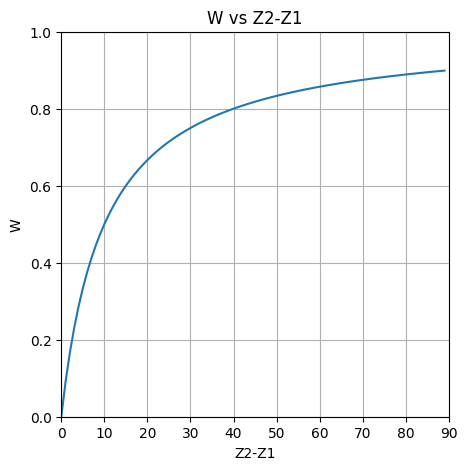

In [27]:
plt.figure(figsize=(5,5))
plt.xlabel("Z2-Z1")
plt.ylabel("W")
plt.grid()
plt.title("W vs Z2-Z1")
plt.xlim(0, 90)
plt.ylim(0, 1)
plt.plot(np.abs(test_Z2-test_Z1), widths)
plt.show()

**3.4 Blur and Focal Length**

Create a function to plot the width of the blur kernel, W, as a function of the focal length of the camera, f. Comment on the relationship between these variables.

STUDENT: INSERT RELATION BETWEEN W AND |Z2-Z1|
$$W = | (\frac{1}{z_1} - \frac{1}{z_2})f\Delta|$$

When focal length increases, the blur also increases linearly, since the range of projection increases linearly due to similarity of triangles. Therefore, linear relationship between focal length and blur kernel width was expected.

In [28]:
test_f = np.arange(0, 100)
test_delta = 5
test_Z1 = 10
test_Z2 = 20
ans_widths = np.load("sol_1/varying_focal_widths.npy")
correct = True
widths = []
for IX, n_f in enumerate(test_f):
    widths.append(compute_blur_kernel_width(test_Z1, test_Z2, n_f, test_delta))
    correct = correct and check_code_correctness(compute_blur_kernel_width, test_Z1, test_Z2, n_f, test_delta, test_out=ans_widths[IX])
if correct:
    print("All tests passed!")

All tests passed!


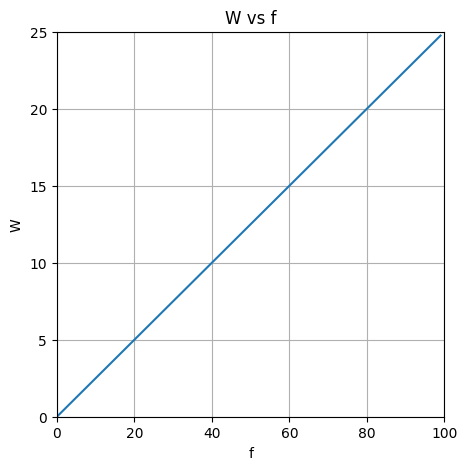

In [29]:
plt.figure(figsize=(5,5))
plt.xlabel("f")
plt.ylabel("W")
plt.grid()
plt.title("W vs f")
plt.xlim(0, 100)
plt.ylim(0, 25)
plt.plot(test_f, widths)
plt.show()

**3.5 Blur and Circle of Confusion (No extra credit CYU)**

Can you relate the blur to circle of confusion? How would you rederive the blur size using the circle of confusion?

**References**

[1] Todor Georgeiv and Chintan Intwala. Light field camera design for integral view photography.

[2] Marc Levoy, Billy Chen, Vaibhav Vaish, Mark Horowitz, Ian McDowall, and Mark Bolas. Synthetic aperture
confocal imaging. ACM Trans. Graph., 23(3), August 2004.

[3] J. P. Lewis. Fast normalized cross-correlation, 1995.

[4] Andrew Lumsdaine and Todor Georgiev. The focused plenoptic camera. In In Proc. IEEE ICCP, pages 1–8, 2009.